# **Finding Lane Lines on the Road** 
***
Here we use the tools learned in Lesson 1 of Udacity's self-driving course to identify lane lines on the road.

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


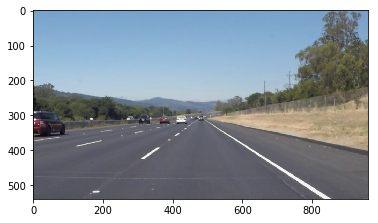

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

# Helper functions

In [3]:
import math
import pandas as pd

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny_params(img, sigma=0.33):
    # idea borrowed from: http://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
    v = np.median(img)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return lower,upper

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, mod=False):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if mod:
        draw_lines_mod(line_img, lines)
    else:
        draw_lines(line_img, lines)
    return line_img


def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    
    def slope_xy(x1,y1,x2,y2):
        return (y2-y1)/(x2-x1)
    
    def within_slope_xy(x1,y1,x2,y2,left_slope,right_slope,tolerance):
        x_center = (x1+x2)/2
        mid_point = 500 # center of the lanes
        slope = slope_xy(x1,y1,x2,y2)
        within_left = left_slope-tolerance < slope < left_slope+tolerance
        within_right = right_slope-tolerance < slope < right_slope+tolerance
        left_lane = within_left and (x_center < mid_point)
        right_lane = within_right and (x_center > mid_point)
        return left_lane or right_lane
    # Observations lead to:
    left_slope = -0.76
    right_slope = 0.55
    tolerance = 0.2
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if within_slope_xy(x1,y1,x2,y2, left_slope, right_slope, tolerance):
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_lines_mod(img, lines, color=[255, 0, 0], thickness=8):
    """
    Create a pandas DataFrame from the line segments and add useful columns.
    """
    
    line_df = pd.DataFrame([el[0] for el in lines],columns=["x1","y1","x2","y2"])
    def mid_x(row):
        return (row["x1"] + row["x2"])/2

    def mid_y(row):
        return (row["y1"] + row["y2"])/2

    def left_or_right_or_ignore(row):
        """
        If a line is within tolerances it is either left or right.
        Otherwise we ignore it.
        """
        left_slope = -0.74 # -0.69
        right_slope = 0.63 # 0.65
        tolerance = 0.15
        mid_x_scene = 480
        slope = row['slope']
        x_in_scene = row['mid_x']
        
        if ((left_slope-tolerance) < slope < (left_slope+tolerance))\
            and x_in_scene < mid_x_scene:
            return "left"
        elif ((right_slope-tolerance) < slope < (right_slope+tolerance))\
            and x_in_scene > mid_x_scene:
            return "right"
        else:
            return "ignore"

    def slope_xy(row):
        x1, y1, x2, y2 = row['x1'],row['y1'],row['x2'],row['y2']
        return (y2-y1)/(x2-x1)

    def line_length(row):
        x1, y1, x2, y2 = row['x1'],row['y1'],row['x2'],row['y2']
        return math.hypot(x2-x1, y2-y1)

    line_df.loc[:,"slope"] = line_df.apply(slope_xy, axis=1)
    line_df.loc[:,"mid_x"] = line_df.apply(mid_x, axis=1)
    line_df.loc[:,"mid_y"] = line_df.apply(mid_y, axis=1)
    line_df.loc[:,"left_or_right"] = line_df.apply(left_or_right_or_ignore,axis=1)
    line_df.loc[:,"length"] = line_df.apply(line_length, axis=1)
    
    left_lines_sub = line_df[line_df['left_or_right']=='left']
    right_lines_sub = line_df[line_df['left_or_right']=='right']
    
    left_x1s = left_lines_sub['x1'].values
    left_x2s = left_lines_sub['x2'].values
    left_y1s = left_lines_sub['y1'].values
    left_y2s = left_lines_sub['y2'].values

    right_x1s = right_lines_sub['x1'].values
    right_x2s = right_lines_sub['x2'].values
    right_y1s = right_lines_sub['y1'].values
    right_y2s = right_lines_sub['y2'].values
    
    x_left_arr = np.concatenate((left_x1s,left_x2s))
    y_left_arr = np.concatenate((left_y1s,left_y2s))
    x_right_arr = np.concatenate((right_x1s,right_x2s))
    y_right_arr = np.concatenate((right_y1s,right_y2s))
    
#     cols = ['slope','mid_x','mid_y','length']
#     print(line_df.groupby("left_or_right")\
#           .agg([np.median, np.mean, np.std,"count"])[cols].T)
    

    left_lane_fit = np.polyfit(x=x_left_arr, y=y_left_arr,deg=1)
    right_lane_fit = np.polyfit(x=x_right_arr, y=y_right_arr,deg=1)
    
    
    slope_L = left_lane_fit[0]
    intercept_L = left_lane_fit[1]
    slope_R = right_lane_fit[0]
    intercept_R = right_lane_fit[1]
    y_low = img.shape[0]
    y_high = 320 # same as vertices
    
    def line_from_mby(slope,intercept,y2,y1):
        # Given end points in y, a slope, and intercept, return (x1,y1,x2,y2)
        def x_from_ymb(y,m,b):
            # solve y=mx+b for x
            return (y-b)/m
        x1 = x_from_ymb(y1,slope,intercept)
        x2 = x_from_ymb(y2,slope,intercept)
        return (int(x1),int(y1),int(x2),int(y2))
    
    left_lane = line_from_mby(slope_L, intercept_L, y_high, y_low)
    right_lane = line_from_mby(slope_R, intercept_R, y_high, y_low)
    
    for lane_line in [left_lane, right_lane]:
        x1, y1, x2, y2 = lane_line
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Here we test the pipeline on images in the test directory. We do this before applying the algorithms to video.

In [4]:
import os
test_images = os.listdir("test_images/")
images = [os.path.join("test_images",image_file) for image_file in test_images
         if "modified" not in image_file]

images

['test_images/solidWhiteCurve.jpg',
 'test_images/whiteCarLaneSwitch.jpg',
 'test_images/solidYellowCurve.jpg',
 'test_images/solidYellowCurve2.jpg',
 'test_images/solidYellowLeft.jpg',
 'test_images/solidWhiteRight.jpg']

In [5]:
# Hard coding in vertices for region of interest
im0 = np.copy(image)
vertices_left = np.array([[120,im0.shape[0]],
                          [430, 320],
                          [500,320],
                          [250, im0.shape[0]]])

vertices_right = np.array([[780,im0.shape[0]],
                           [460, 320],
                           [570,320],
                           [im0.shape[1]-20,im0.shape[0]]])
verts = [vertices_left, vertices_right]

def pipeline_wrapper(img, vertices_list, mod=False):
    """
    pipeline used to chain helper functions.
    """
    im0 = np.copy(img)
    im1 = grayscale(im0)
    kernel_size = 3 # 5
    im2 = gaussian_blur(im1,kernel_size)
    low_threshold, high_threshold = canny_params(im0,0.9)
    im3 = canny(im2,low_threshold,high_threshold)
    im4 = region_of_interest(im3, vertices_list)
    if mod:
        im5 = hough_lines(im4, rho=2, theta=1*np.pi/180, threshold=50,
                          min_line_len=100, max_line_gap=100, mod=True)        
#         im5 = hough_lines(im4, rho=10, theta=1*np.pi/180, threshold=20,
#                           min_line_len=20, max_line_gap=20, mod=True)
    else:
        im5 = hough_lines(im4, rho=2, theta=1*np.pi/180, threshold=50,
                          min_line_len=100, max_line_gap=100)
    im6 = weighted_img(im5, im0, α=0.8, β=1., λ=0.)
    return im6

In [6]:
def read_image(image_path):
    """ helper for loading image
    """
    image = mpimg.imread(image_path)
    return image

### Outputs on images look good!

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


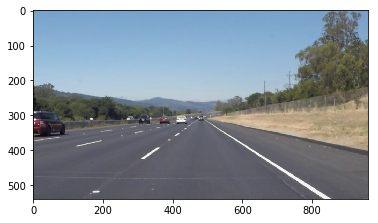

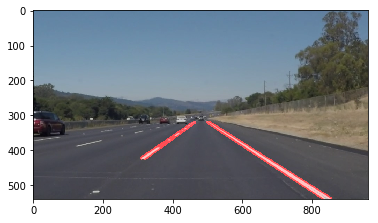

In [7]:
img = read_image(images[5]) # images[0 -> 5]
fig1 = plt.figure(1)
plt.imshow(img)
fig1.show()

img_out = pipeline_wrapper(img,verts)
fig2 = plt.figure(2)
plt.imshow(img_out)
fig2.show()

### Saving images
Run this once to save output images.

In [8]:
# for test_image in images:
#     img = read_image(test_image)
#     img_out = pipeline_wrapper(img,verts)
#     plt.imshow(img_out)
#     plt.savefig(test_image[:-4]+"_modified.jpg")    

## Test on Videos

There are two test videos we try our code on, the second one being more challenging.

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(image):
    """
    We simply run the image through our pipeline wrapper.
    """
    result = pipeline_wrapper(image,verts)
    return result

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:04<00:00, 51.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 8.66 s, sys: 264 ms, total: 8.92 s
Wall time: 4.68 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

This works well to pull out the line segments. Let's see if we can extrapolate these line segments to one line per side, using `draw_lines_mod` which first places all line segments in a pandas dataframe for manipulation and easy analysis/debugging:

In [13]:
def process_image_mod(image):
    """ This function calls the pipeline wrapper with draw_lines_mod
    """
    result = pipeline_wrapper(image,verts, mod=True)
    return result

In [14]:
white_output_mod = 'white_mod.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image_mod) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output_mod, audio=False)

[MoviePy] >>>> Building video white_mod.mp4
[MoviePy] Writing video white_mod.mp4


100%|█████████▉| 221/222 [00:06<00:00, 34.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white_mod.mp4 

CPU times: user 10.8 s, sys: 224 ms, total: 11.1 s
Wall time: 6.71 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output_mod))

Now for the one with the solid yellow lane on the left. For this one we use a modified version of the `draw_lines` function: `draw_lines_mod`.

In [16]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_mod) # changed to `mod` version
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:20<00:00, 33.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 34.4 s, sys: 660 ms, total: 35 s
Wall time: 20.9 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Got some boss feedback from the Udacity Mentor who offered some advice for parameter values, mainly for the Hough Transformations. This helped a lot with the lane lines. I wonder how I could easily arrive at optimal values next time. Will have to think about automated optimisation, which really comes down to defining and creating useful metrics.

The first video didn't give me much trouble, but I spent a bit of time on the next one! I occasionally had lines that would flash in between scenes that were nonsensical. I tried many, many different things and in the end I had what almost amounts to a self-inflicted bug. I was using the mid-points of each line returned from the Hough transformations to feed into the np.polyfit algo, which of course has the potential to bug out as canny edge detection produces two lines per lane line, as there are two edges of the thick line. So this becomes reduced to two points separated horizontally, when I use the midpoints, also losing the length information of the lane line. Foolish. As a result though, I trouble shooted every line of code, and really understood what every helper function was doing... so kinda useful...

My approach was to first get a pipeline working that included the helper functions, but didn't really do anything useful. Then I would explore the outputs of each one, and iteratively place the helpers in a sequence that made logical sense. For example first I was doing region selection, then some processing, then another round of region selection. Without fine tuning the first few steps I realised I could just include one call of the region selection, right before the Hough transformations.

Only after I was happy with the order of helper functions, and I was confident I knew enough about how each one behaved, did I start tweaking the parameters and including short functions of my own. Here, I had a lot of ideas, but just worked on ones that sounded fun and would be easy to code and efficient.

One cool idea would be to automatically pull out the vertices for the region of interest mask. I could do this by crudely detecting lines (cheaply, even with noise), and then draw a fairly tight polygon around it (like a triangle with a flat top). I imagined I would run into problems so I didn't explore this idea.

If there were markings on the road, within the lane lines, my pipeline could be fooled. If for example this was shown some Chinese or Japanese roads, where their writing has a lot of straight lines, and at different angles, my algo could potentially see some as lane lines. These writings are often in the same colour as the lane lines, so this could trip my pipeline. My algo would also fail when changing lanes... whoops! Hard coding in the region of interest might not be the best idea for a generalised algo. Works here though.. gotta solve one thing at a time...

Another thought: how was I evaluating this? By eye. I was simply applying the different functions either one-by-one or by multiples, and eye-balling the outputs. While this is good for building intuition, it is very slow. And only qualititative. I don't have any quantitative metrics that I created so it is difficult to optimise after a certain point. Given the project specs, and the short timeline, this is acceptable, but if I was doing this for work, or for a real project I would get quantitative.

## Optional Challenge

My algorithm trips hard on the optional challenge video. I will come back to this.

In [18]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

OSError: MoviePy error: the file challenge.mp4 could not be found !
Please check that you entered the correct path.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))